지난번 01_mnist_dataset_numpy 노트북을 성공적으로 수행하신 분들이라면 mnist dataset 중에서 0,1 로만 이루어진 x_train, y_train 을 만드셨을텐데요. 오늘을 이를 이용해서 numpy 를 가지고 logistic regression 을 한번 구현해보도록 합시다. ( 지난번 linear regression 과 마찬가지로 마지막에는 pytorch 를 이용해서도 한번 구현해보도록 하겠습니다. )

그럼 먼저 데이터셋을 한번 준비해볼까요? 지난번 


In [1]:
import numpy as np
from urllib import request
import matplotlib.pyplot as plt
import gzip

filename = [
["x_train", "train-images-idx3-ubyte.gz"],
["x_test", "t10k-images-idx3-ubyte.gz"],
["y_train", "train-labels-idx1-ubyte.gz"],
["y_test", "t10k-labels-idx1-ubyte.gz" ],
]

base_url = "http://yann.lecun.com/exdb/mnist/"

# CHALLENGE 연습문제 ( 해보고 싶은 분들은 만들어보세요. )
# 매번 Lecun 교수님의 홈페이지에 가서 dataset 을 다운로드 해오는 것은 큰 낭비입니다. 
# 이미 다운로드한 파일들이 있을때 다운로드를 안해도 되도록 코드를 수정해봅시다 :)


# filename list 에서 하나씩 file 이름들을 가져옵니다. 
for n in filename:
    request.urlretrieve(base_url+n[1],n[1])
    print("%s downloaded " % base_url+n[1])

print("download has been completed.")

# dictionary 에 'x_train', 'y_train', 'x_test', 'y_test' 라는 key 로 저장합니다.
mnist = {}

# train, test image 를 가져와서 dictionary 에 넣습니다.  x_train, y_train 에 넣습니다. 
for name in filename[:2]:
    with gzip.open(name[1], 'rb') as f:
        mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28,28)
        
for name in filename[2:]:
    with gzip.open(name[1], 'rb') as f:
        mnist[name[0]] = np.frombuffer(f.read(),np.uint8, offset=8).reshape(-1,1)
        
# training data, label 의 shape 을 살펴봅시다. 
print(mnist['x_train'].shape)
print(mnist['y_train'].shape)

# test data, label 의 shape 을 살펴볼까요?
print(mnist['x_test'].shape)
print(mnist['y_test'].shape)



http://yann.lecun.com/exdb/mnist/ downloaded train-images-idx3-ubyte.gz
http://yann.lecun.com/exdb/mnist/ downloaded t10k-images-idx3-ubyte.gz
http://yann.lecun.com/exdb/mnist/ downloaded train-labels-idx1-ubyte.gz
http://yann.lecun.com/exdb/mnist/ downloaded t10k-labels-idx1-ubyte.gz
download has been completed.
(60000, 28, 28)
(60000, 1)
(10000, 28, 28)
(10000, 1)


데이터넷은 0 에서 9 까지의 모든 숫자들을 담고 있습니다. 여기에서 2,4 만으로 이루어져 있는 dataset 을 만들어 볼까요?  ( 원래 0, 1 로 데이터셋을 만들었는데, 두개의 변별력이 너무 없어서 우리의 허름한 logistic regression model 이 너무 학습이 안되길래 2,4 로 변경했습니다.  Real World AI 는 깔끔하게 정리된 tutorial 이랑 너무 많이 다릅니다. 다양한 시행착오를 계속해서 쌓아두지 않으면 큰 낭패를 보기 쉽습니다. )
x_train, y_train, x_test, y_test 를 만들어 봅시다.

In [2]:
def dataset_filter( x, y ):  
    mask_2 = ( y == 2 )
    mask_4 = ( y == 4 ) 
    mask = mask_2 + mask_4
    mask = mask.T
    mask = mask[0]  # 역설적이면 rank-1 row vector 로 변경함 
    # 2,4 인 데이터들만 꺼내서 새로운 numpy array 를 구성합니다. 
    x_filtered = x[mask,:]
    y_filtered = y[mask,:]
    # 숫자 2 의 레이블을 0, 숫자 4의 레이블을 1 로 바꾸어줍니다. (logistic regression 이니까요.)
    y_filtered[ np.where(y_filtered==2)] = 0
    y_filtered[ np.where(y_filtered==4)] = 1
    return x_filtered, y_filtered

x_train, y_train = dataset_filter( mnist['x_train'], mnist['y_train'])
x_test, y_test = dataset_filter( mnist['x_test'], mnist['y_test'])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(11800, 28, 28) (11800, 1)
(2014, 28, 28) (2014, 1)


총 60,000 개의 데이터셋에서 0,1 데이터만 꺼내니까  training set 은 12,665개, test set은 2,115 개의 데이터만 남는군요. 제대로 처리가 되었는지 테스트해볼까요?

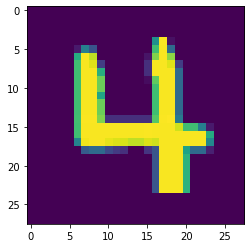

[1]


In [3]:
import matplotlib.pyplot as plt

# 1000 번째 index 에 들어있는 데이터를 한번 출력해봅시다. 
img = x_train[1000,:]
plt.imshow(img)
plt.show()

# Label 과 매치하는지 살펴볼까요? 
print(y_train[1000])

자 이제 numpy 를 이용해서 dataset 준비는 제대로 완료되었습니다. 이제 logistic regression 을 구현해보도록 합시다.

28 x 28 이미지로 되어있는 2차원의 이미지를 28 * 28 (784) 개의 1D array 로 한번 Flatten 시켜볼까요? 2차원, 3차원으로 구성되어 있는 데이터를 1차원의 column vector 로 쭉 펼치는 과정을 Flatten 한다고 이야기합니다. 나중에 Neural Net 에서 Convolutional Neural Network 에서 Fully Connected Layer 로 연결할때 Flatten 을 사용하게 됩니다. 

In [4]:
# 0~255 로 되어 있는 값을 0~1 사이로 normalize 해줍니다.
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# dataset 의 dimension 을  ( n_x * m ), label 의 dimension 을 ( 1 * m) 으로 변경합니다.
# 왜 이렇게 만드는지는 '이론교육자료'를 참고하도록 합시다. :)  matrix dimension 맞추기가 머리가 아파오기 시작하시죠 ㅎㅎㅎ 
x_train, y_train = x_train.reshape(-1,28*28).T, y_train.T
x_test, y_test = x_test.reshape(-1,28*28).T, y_test.T

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(11800, 28, 28) (11800, 1)
(2014, 28, 28) (2014, 1)
(784, 11800) (1, 11800)
(784, 2014) (1, 2014)


이제 Logistic regression 의 본격적인 training 을 시작해볼까요.

__( 여기 즈음에서 Logistic Regression 의 이론교육자료를 첨부할 예정입니다. 
  이론교육자료는 아직 만들지를 않아서 만들고 나면 이곳에 링크를 첨부해두도록 하겠습니다. )__

입력하는 데이터셋의 feature 의 갯수는 X1, X2, ...., X784 까지 총 784 개이고, training dataset 의 갯수는 12,665 개가 되겠네요.  training dataset 의 용량을 계산해보면 ( 12665 * 784 bytes 인데 ) 약 9MB 정도밖에 안하네요. 따로 mini-batch 를 나눌필요없이 전체의 dataset 을 하나의 epoch 으로 다 처리하는데 무리가 없을 것 같네요.

입력데이터의 feature dimension 이 784 이기 때문에, weight 는 784 개의 column vector 를 만들면 되겠고, bias 는 real number 1 개만 있으면 되겠네요. 

__( mini-batch 의 개념은 hidden layer 가 존재하는 제대로 된 neural network 을 만들때 구현해보도록 하겠습니다. )__

In [5]:
# sigmoid 함수를 정의합니다. 
def sigmoid_f( x ):
    return 1/(1+np.exp(-x))
# cross-entropy loss 함수를 정의합니다. 
def loss_f( a, y ):
    return -(np.dot(y.T,np.log(a)) + np.dot((1 - y.T),np.log(1- a)))
    
# hyper parameter 를 정의합니다. 
epoch = 200
learning_rate = 0.00005
m = len(x_train)  # dataset 의 갯수를 의미합니다. 

# 학습을 시킬 parameter  를 준비합니다. 
w = np.random.normal(0, 0.1 ,size=(784,1)) # np.random.random((784,1))
b = np.zeros((1,1)) # np.random.random((1))

loss_trail = []

for i in range(epoch):
    z = np.dot(w.T, x_train) + b
    a = sigmoid_f(z)
    loss = loss_f(a,y_train)
    loss_m = np.sum(loss)/m
    print("epoch: %d, loss: %f" %(i,loss_m))
    loss_trail.append(loss_m)
    dz = a - y_train
    db = 1/m * np.sum(dz)
    dw = 1/m * np.dot(x_train, dz.T)
    
    w = w - learning_rate * dw
    b = b - learning_rate * db
    

epoch: 0, loss: 152781.607446
epoch: 1, loss: 152498.768295
epoch: 2, loss: 152219.698167
epoch: 3, loss: 151944.365508
epoch: 4, loss: 151672.738728
epoch: 5, loss: 151404.786207
epoch: 6, loss: 151140.476306
epoch: 7, loss: 150879.777370
epoch: 8, loss: 150622.657739
epoch: 9, loss: 150369.085754
epoch: 10, loss: 150119.029764
epoch: 11, loss: 149872.458136
epoch: 12, loss: 149629.339257
epoch: 13, loss: 149389.641545
epoch: 14, loss: 149153.333453
epoch: 15, loss: 148920.383478
epoch: 16, loss: 148690.760167
epoch: 17, loss: 148464.432120
epoch: 18, loss: 148241.368002
epoch: 19, loss: 148021.536544
epoch: 20, loss: 147804.906553
epoch: 21, loss: 147591.446913
epoch: 22, loss: 147381.126597
epoch: 23, loss: 147173.914665
epoch: 24, loss: 146969.780278
epoch: 25, loss: 146768.692694
epoch: 26, loss: 146570.621282
epoch: 27, loss: 146375.535520
epoch: 28, loss: 146183.405005
epoch: 29, loss: 145994.199453
epoch: 30, loss: 145807.888709
epoch: 31, loss: 145624.442746
epoch: 32, loss: 1

loss 가 제대로 떨어지는지 한번 그래프를 그려보도록 합시다.

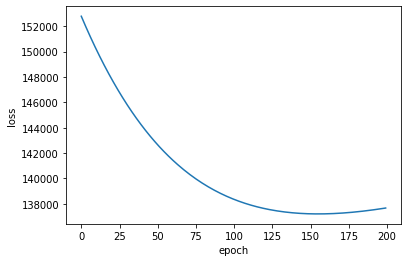

In [8]:
plt.plot(range(len(loss_trail)), loss_trail)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

x_test, y_test 로 준비해놓은 test set 을 이용해서 학습이 얼마나 잘 되었는지 한번 확인해보도록 합시다. 

잠깐 질문! 위 모델에서 우리가 학습을 한 parameter 는 무엇이고, 그 parameter 의 dimension 을 얼마일까요? 

그럼 우리가 학습한 모델을 이용해서 test 를 한번 해보도록 합시다. 

In [35]:
# w,b 의 dimension 을 확인해보도록 합시다.
print(w.shape, b.shape)

out = sigmoid_f( np.dot(w.T, x_test) + b)
#  out 의 값과 y_test 의 dimension 은 당연히 같아야 되겠지요?
print(out.shape, y_test.shape)

# sigmoid 출력값중에 0.5 를 넘는 곳은 True 로 marking 합니다. 
out = out >= 0.5
y_test = y_test == 1

# 몇개를 제대로 예측했는지 한번 살펴볼까요? 
true_prediction = ( out == y_test )
print( np.sum( true_prediction ) / y_test.shape[1] )

(784, 1) (1, 1)
(1, 2014) (1, 2014)
0.7279046673286991


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


(2014, 28, 28)
False


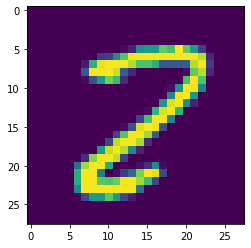

In [33]:
x_test *= 255.0

images = (x_test.T).reshape(-1,28,28)
print(images.shape)
# 1000 번째 index 에 들어있는 데이터를 한번 출력해봅시다. 
img = images[100,:]
print(y_test[0][100])
plt.imshow(img)
plt.show()

